In [18]:
import os, glob, json, pickle, datetime, pathlib
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

from stable_baselines3 import SAC          # ou A2C, DQN…
import gymnasium as gym
import highway_env                         # noqa: enregistre les envs

# chemins projet ---------------------------------------------------------------
ROOT      = pathlib.Path("../..").resolve()
LOG_DIR   = ROOT / "logs" / "sac_main"      # dossier TensorBoard
MODEL_FN  = ROOT / "models" / "sac_racetrack.zip"
CFG_FN    = ROOT / "configs" / "config3.pkl"   # config Highway (optionnel)
assert MODEL_FN.is_file(), "🙅 Modèle non trouvé"


In [19]:
model = SAC.load(MODEL_FN, env=None)     


In [21]:
def latest_run(log_dir, prefix="PPO"):      # sb3 crée « PPO_1 », « PPO_2 », …
    runs = sorted(glob.glob(os.path.join(log_dir, f"{prefix}_*")))
    if not runs:                            # fallback : dossier unique
        runs = [log_dir]
    assert runs, f"Aucun dossier TensorBoard dans {log_dir}"
    return runs[-1]

TB_DIR = latest_run(LOG_DIR, prefix="SAC")  # ↩ changez le préfixe si besoin
print("Logs →", TB_DIR)


Logs → /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/logs/sac_main


In [25]:
from tensorboard.backend.event_processing import event_accumulator

LOG_PARENT = "/usr/users/streamingjailbreakdetection/elbarichi_moh/"\
             "Reinforcement-Learning-Project/task3/logs/sac_main2"

events = sorted(
    glob.glob(os.path.join(LOG_PARENT, "**", "events.out.tfevents.*"),
              recursive=True)
)
assert events, f"Aucun event file trouvé sous {LOG_PARENT}"

EV_FILE = events[-1]


print("\n--> On chargera :", EV_FILE)

ea = event_accumulator.EventAccumulator(EV_FILE, size_guidance={"scalars": 0})
ea.Reload()

print("Scalars disponibles :", ea.Tags()["scalars"][:10], "…")



--> On chargera : /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/logs/sac_main2/main_run_1/events.out.tfevents.1745516374.chome.2977789.1
Scalars disponibles : ['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/actor_loss', 'train/critic_loss', 'train/ent_coef', 'train/ent_coef_loss', 'train/learning_rate'] …


In [26]:

def plot_metric(tag, smooth=20, ax=None):
    """Trace le scalaire `tag` + moyenne glissante (smooth points)."""
    events  = ea.Scalars(tag)
    steps   = np.array([e.step  for e in events])
    values  = np.array([e.value for e in events])

    if ax is None:
        _, ax = plt.subplots(figsize=(6,4))

    ax.plot(steps, values, label=tag.split("/")[-1], lw=1.2)

    if len(values) > smooth:
        kernel = np.ones(smooth) / smooth
        sm_val = np.convolve(values, kernel, mode="valid")
        sm_stp = steps[smooth-1:]
        ax.plot(sm_stp, sm_val, lw=2, ls="--", label=f"avg {smooth}")

    ax.set_xlabel("Timesteps"); ax.grid(alpha=.3)
    return ax


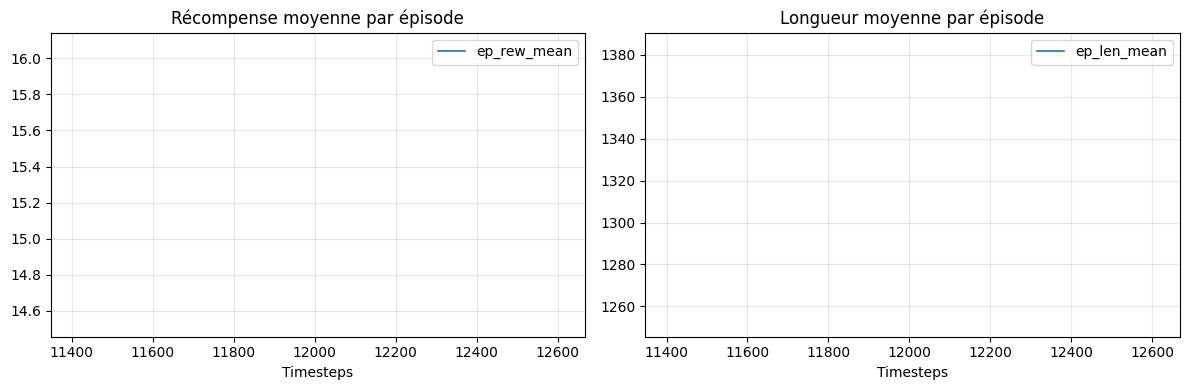

In [27]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
plot_metric("rollout/ep_rew_mean", ax=axs[0])
plot_metric("rollout/ep_len_mean", ax=axs[1])
axs[0].set_title("Récompense moyenne par épisode")
axs[1].set_title("Longueur moyenne par épisode")
for ax in axs: ax.legend()
plt.tight_layout(); plt.show()


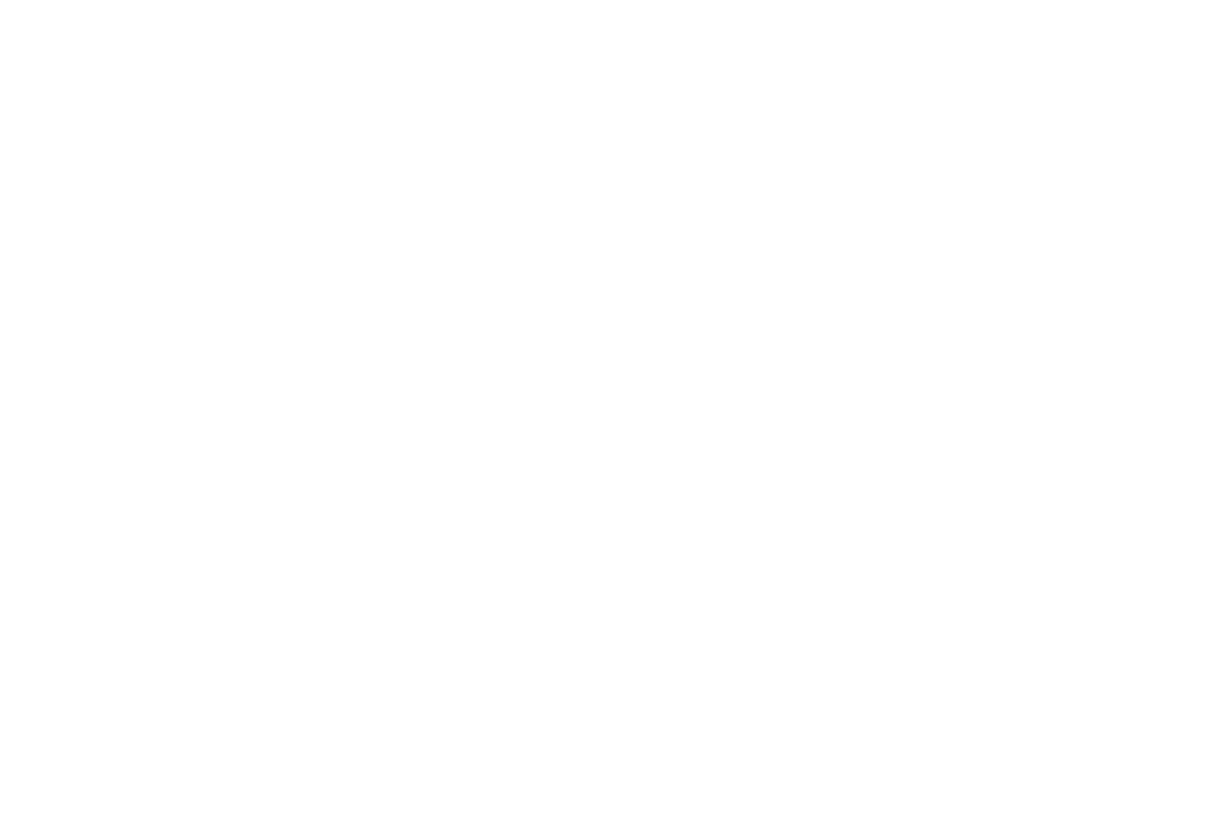

In [28]:
tags = ["train/loss", "train/policy_loss", "train/value_loss", "train/entropy_loss"]
fig, axes = plt.subplots(2,2, figsize=(12,8))
for tag, ax in zip(tags, axes.flatten()):
    if tag in ea.Tags()["scalars"]:
        plot_metric(tag, smooth=50, ax=ax)
        ax.set_title(tag.replace("_"," ").split("/")[-1].capitalize())
        ax.legend()
    else:
        ax.set_visible(False)
plt.tight_layout(); plt.show()


In [ ]:
with open(CFG_FN, "rb") as f: cfg = pickle.load(f)   # facultatif
def make_env():
    return gym.make("racetrack-v0", render_mode=None, config=cfg)

def evaluate(model, n_ep=10):
    rs, ls = [], []
    env = make_env()
    for ep in range(n_ep):
        obs, _ = env.reset(); done = truncated = False
        R = 0; l = 0
        while not (done or truncated):
            act, _ = model.predict(obs, deterministic=True)
            obs, r, done, truncated, _ = env.step(act)
            R += r; l += 1
        rs.append(R); ls.append(l)
    env.close()
    return dict(mean_R=np.mean(rs), std_R=np.std(rs),
                mean_L=np.mean(ls), std_L=np.std(ls))

metrics = evaluate(model, n_ep=20)
print(json.dumps(metrics, indent=2))


In [ ]:
CFG_FILE  = ROOT / "configs" / "config3.pkl"   # même config qu'à l'entraînement

with open(CFG_FILE, "rb") as f:
    cfg = pickle.load(f)

# env mono-process pour l’évaluation (render RGB)
eval_env = gym.make("racetrack-v0",
                    render_mode="rgb_array",  # pour afficher dans le notebook
                    config=cfg)

# chargement du modèle
model = SAC.load(MODEL_FN, env=eval_env, device="cpu")       # pas besoin de passer env si on ne re-train pas
print("‣ Modèle chargé :", MODEL_FN)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
‣ Modèle chargé : /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/models/sac_racetrack.zip


In [ ]:

from stable_baselines3.common.evaluation import evaluate_policy

mean_r, std_r = evaluate_policy(model, eval_env,
                                n_eval_episodes=20,
                                deterministic=True,
                                return_episode_rewards=False,
                                warn=False)

print(f"Reward moyenne sur 20 ép. : {mean_r:.1f}  ±{std_r:.1f}")


In [31]:
from IPython.display import HTML
import base64, io

def display_episode(env, model, steps_limit=1500):
    obs, _ = env.reset()
    frames = [env.render()]
    for _ in range(steps_limit):
        act, _ = model.predict(obs, deterministic=True)
        obs, _, done, trunc, _ = env.step(act)
        frames.append(env.render())
        if done or trunc:
            break
    return np.stack(frames)

def show_gif(frames, fps=30):
    import imageio, tempfile, os
    with tempfile.NamedTemporaryFile(suffix=".gif", delete=False) as fp:
        imageio.mimsave(fp.name, frames, fps=fps)
        data = base64.b64encode(open(fp.name,'rb').read()).decode("ascii")
    return HTML(f'<img src="data:image/gif;base64,{data}" />')



In [ ]:
import imageio
from pathlib import Path

frames = display_episode(eval_env, model, steps_limit=1500)   # (T, H, W, 3) uint8

# 2. Dossier + nom du GIF
OUT_DIR  = Path(".") / "gifs"
OUT_DIR.mkdir(exist_ok=True)
gif_path = "racetrack_test.gif"

# 3. Enregistrement
imageio.mimsave(gif_path, frames, fps=30)  

print(f"GIF enregistré : {gif_path.resolve()}")


GIF enregistré : /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/2_A2C/notebooks/gifs/racetrack_test.gif



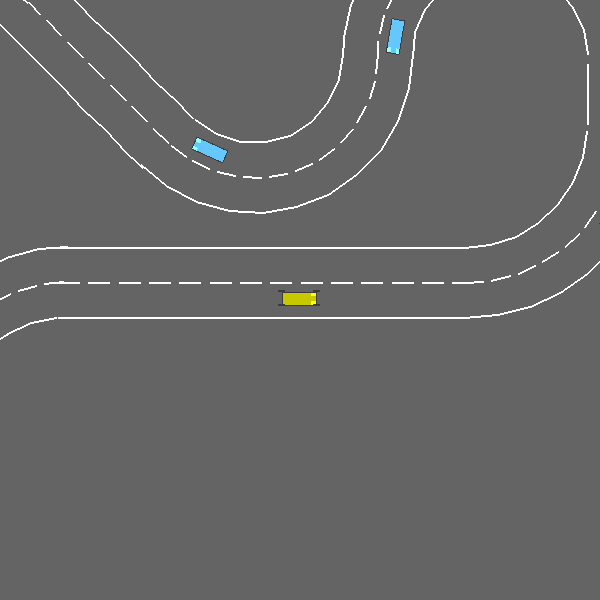

In [33]:
show_gif(frames, fps=30)